# PetroFit Demo: PSF Sersic Fitting using Abell 2744

In [1]:
import warnings
import numpy as np

from astropy.nddata import CCDData, Cutout2D
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.utils.exceptions import AstropyWarning
from astropy.modeling import models

from photutils import source_properties, SourceProperties

In [2]:
from petrofit.segmentation import make_segments, deblend_segments, plot_segments, get_source_position, masked_segm_image, get_source_ellip, get_source_theta
from petrofit.fitting.models import PSFModel
from petrofit.fitting.fitting import fit_plane, model_to_image, fit_model
from petrofit.fitting.utils import plot_fit

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['image.origin'] = 'lower'

In [4]:
import ipywidgets as widgets
from IPython.display import display

DISPLAY_STYLE = {'description_width': 'initial'}

# Load Data

In [5]:
acs_filter_list = ['f435w', 'f606w', 'f814w']
wfc3_filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0/hlsp_frontier_hst_{}-60mas_abell2744_{}_v1.0_drz.fits"

In [6]:
data_paths = {}
for f in acs_filter_list:
    data_paths[f] = input_data_formatter.format('acs', f)
    
for f in wfc3_filter_list:
    data_paths[f] = input_data_formatter.format('wfc3', f)
    
petrosian_cat_collection = {}

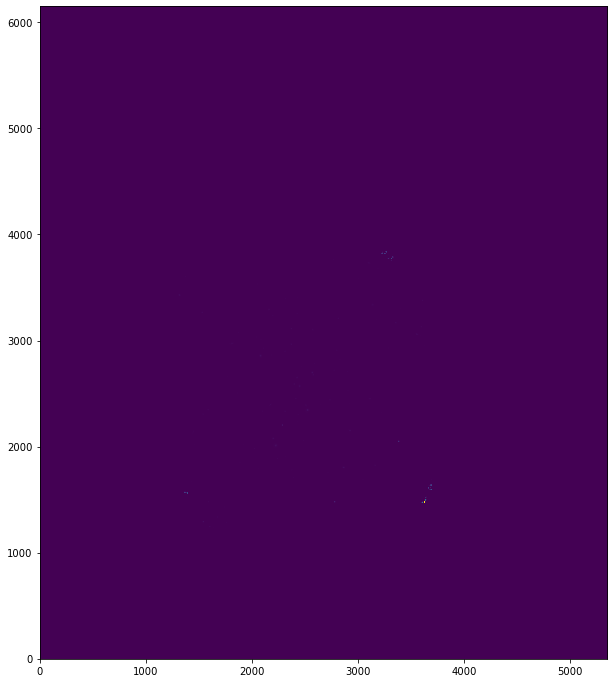

In [7]:
# Load data and vitals
# ---------------------

current_filter = 'f105w'
input_data_path = data_paths[current_filter]
#input_data_path = 'combined_data.fits'
data = CCDData.read(input_data_path, cache=True)

plt.imshow(data, vmin=0, vmax=data.data.std())

### Estimate data noise at dark area

-0.00012860226 0.0038543560076504946 0.010278282687067986


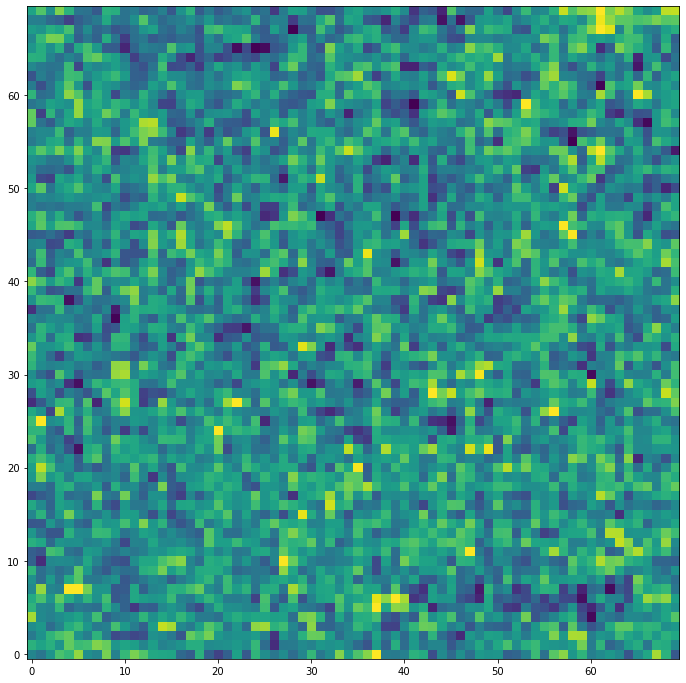

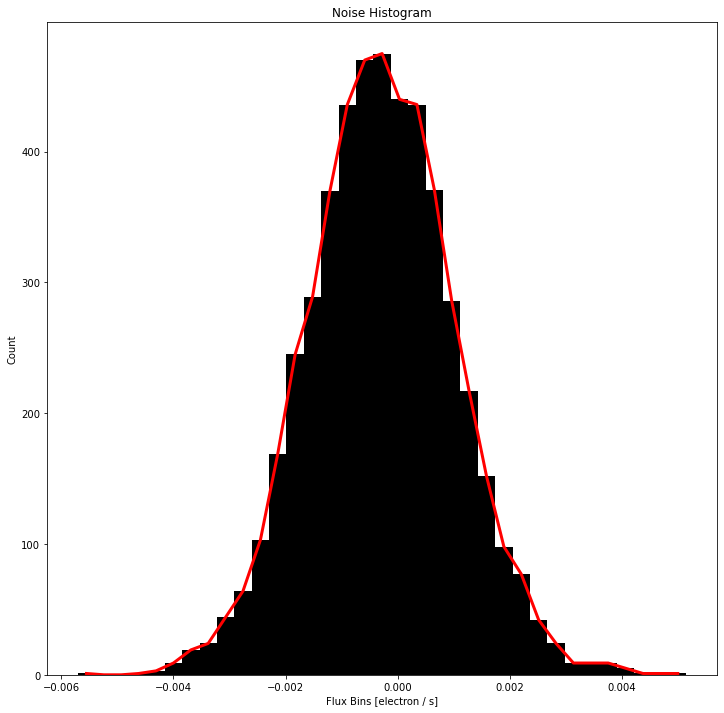

In [8]:
# Estimate data noise at dark area
# --------------------------------
noise_cutout = Cutout2D(data, (2760, 3420), 70)

noise_mean = noise_cutout.data.mean()
noise_sigma = noise_cutout.data.std()
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.

print(noise_mean, noise_3_sigma, noise_8_sigma)

plt.imshow(noise_cutout.data, vmax=noise_mean+noise_3_sigma, vmin=noise_mean-noise_3_sigma)
plt.show()

n, bins, patches = plt.hist(noise_cutout.data.flatten(), bins=35, align='left', color='black')
plt.plot(bins[:-1], n, c='r', linewidth=3)

plt.xlabel('Flux Bins [{}]'.format(str(data.unit)))
plt.ylabel('Count')
plt.title('Noise Histogram')
plt.show()

# PSF

9.3250003e-07 0.07466725 0.00038446748


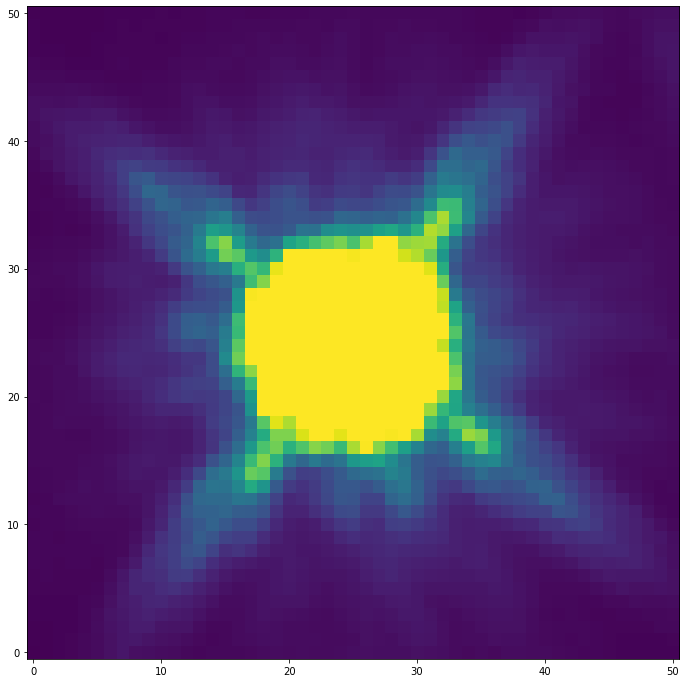

In [9]:
PSF = Cutout2D(data, (6759//2, 4102//2), 50+1).data

PSF = PSF / PSF.sum()

PSF_std = PSF.std()

print(PSF.min(), PSF.max(), PSF.mean())

plt.imshow(PSF, vmin=0, vmax=PSF_std/10)

# Target Image 

0.03231674


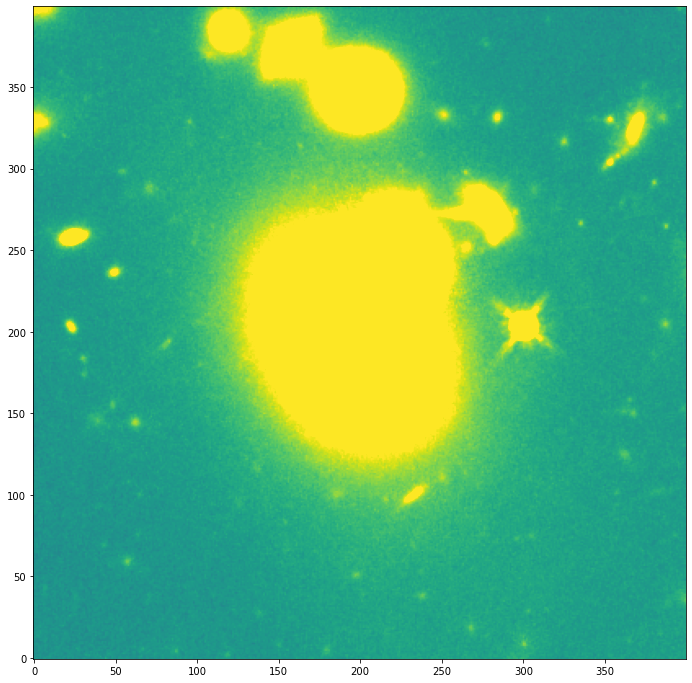

In [10]:
# Cutout Image
# -------------

# Select and crop image:

cx, cy, size = 2083, 2859, 400 # Lone CD galaxy

image = Cutout2D(data, (cx, cy), size, copy=True)

# Compute image stats
image_min = image.data.min()
image_max = image.data.max()
image_mean = image.data.mean()
image_sigma = image.data.std()
image_3_sigma = image_sigma * 3.
image_8_sigma = image_sigma * 8.

image_clipped_mean, image_clipped_median, image_clipped_std = sigma_clipped_stats(image.data, sigma=3.0)

# Subtract Noise
#image.data  -= image_clipped_mean

# Set min and max values for all plots
vmin = -5 * image_clipped_std
vmax = +5 * image_clipped_std

plt.imshow(image.data, vmin=vmin, vmax=vmax)

print(image_mean)

# Segmentation (ID Target)

Num of Targets: 36


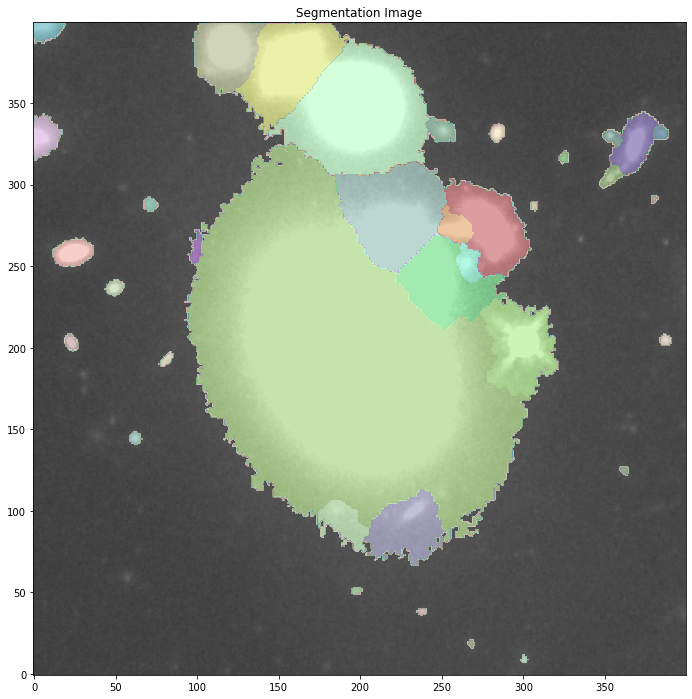

In [11]:
# Catalog
# -------

# Define detect threshold
nsigma = np.ones_like(image.data)
nsigma[:, :] = noise_8_sigma

# Define smoothing kernel
kernel_size = 3
fwhm = 3
npixels = 4**2

# Make segmentation map
segm = make_segments(image.data, nsigma=nsigma, kernel_size=kernel_size, fwhm=fwhm, npixels=npixels)

# Deblend segmentation map
segm_deblend = deblend_segments(image.data, segm, contrast=0, nlevels=50,
                                         kernel_size=kernel_size, fwhm=fwhm, npixels=npixels)
#segm_deblend.remove_border_labels(1)

# Make catalog
cat = source_properties(image.data, segm_deblend, wcs=image.wcs)

# Display source properties
print("Num of Targets:", len(cat))

# Plot segments
plot_segments(segm_deblend, image.data, vmin=vmin, vmax=vmax)
plt.show()

In [12]:
result_cat = cat.to_table()
result_cat.sort(keys="source_sum", reverse=1)

# Cutout Target and Zoom

21 194.0 197.0


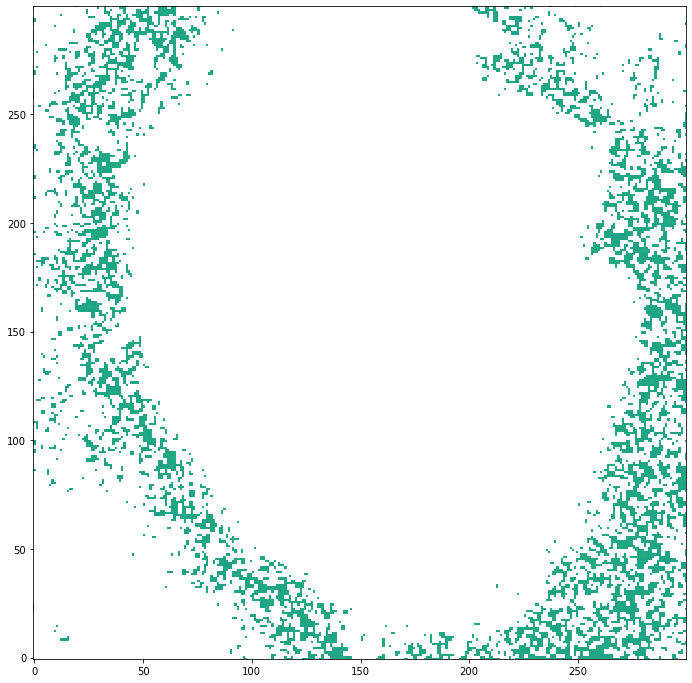

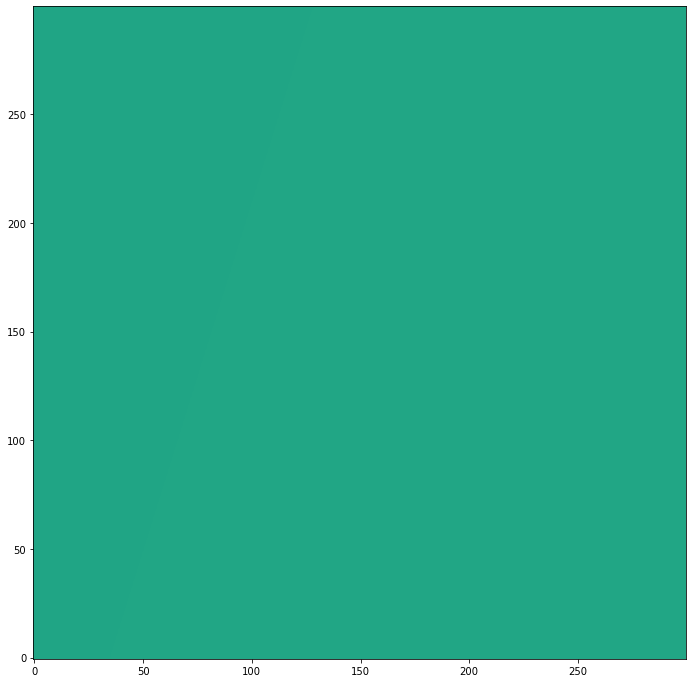

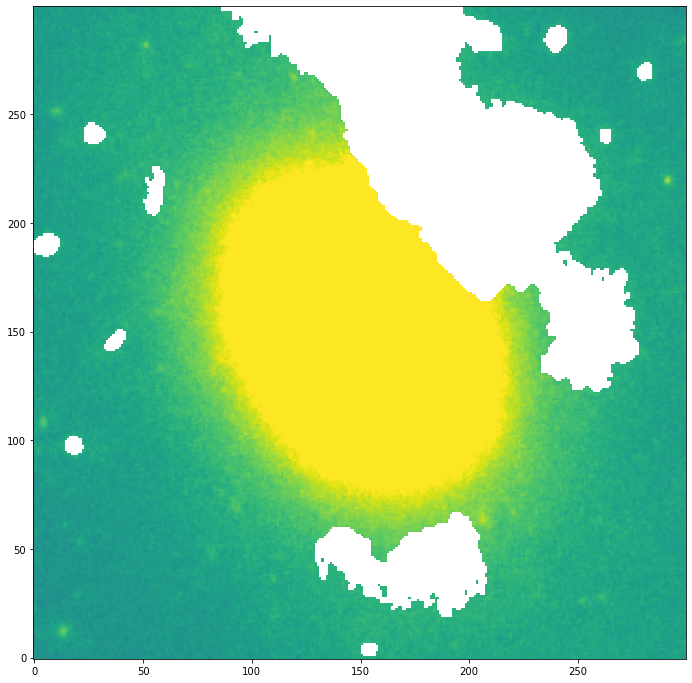

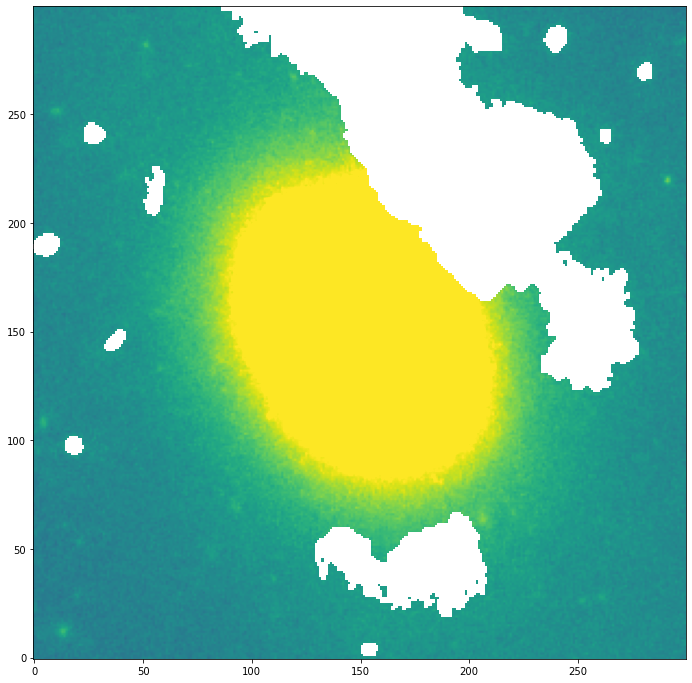

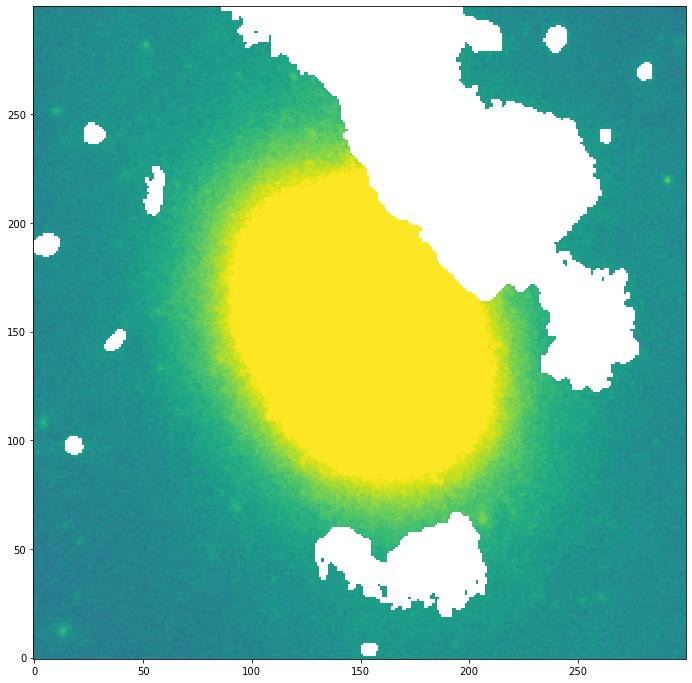

In [13]:
targ_idx = 0
mid = 150#
cutout_size = mid *2
row = result_cat[targ_idx]

x, y = [mid, mid]
x, y = [i.value for i in get_source_position(row)]

#x, y =  360, 460,
print(row['id'], x, y)
# Estimate mean in coutuout

#target_zoom_mask = segm_mask(row['id'], segm_deblend) | segm_mask(row_2['id'], segm_deblend)
#target_zoom_nan_image = deepcopy(image.data)
#target_zoom_nan_image[~target_zoom_mask] = np.nan

target_zoom_nan_image = masked_segm_image(row['id'], image, segm_deblend, fill=np.nan, mask_background=False)
target_zoom_nan_image = Cutout2D(target_zoom_nan_image.data, (x, y), cutout_size, mode='partial', fill_value=np.nan)
mean, median, std = sigma_clipped_stats(target_zoom_nan_image.data, sigma=1.0, 
                                        mask=np.isnan(target_zoom_nan_image.data) 
                                       )


# Make coutuout
target_zoom = target_zoom_nan_image.data #- median 

target_zoom_raw_image = Cutout2D(image.data, (x, y), cutout_size, mode='partial', fill_value=np.nan, copy=True).data

masked_stats_image = target_zoom_nan_image.data
masked_image = target_zoom
sigma = 1
sigma_type = 'clip'
if True:#len(np.where(~np.isnan(masked_stats_image))[0]) > 10:
    with warnings.catch_warnings():

        warnings.simplefilter('ignore', AstropyWarning)
        if sigma_type.lower() == 'clip':
            mean, median, std = sigma_clipped_stats(masked_stats_image, sigma=sigma,
                                                mask=np.isnan(masked_stats_image.data))

            fit_bg_image = masked_stats_image 
            fit_bg_image = sigma_clip(fit_bg_image, sigma)

        elif sigma_type.lower() == 'bound':
            mean, median, std = sigma_clipped_stats(masked_stats_image, sigma=3, 
                                                    mask=np.isnan(masked_stats_image.data))

            fit_bg_image = masked_stats_image
            fit_bg_image[np.where(fit_bg_image > mean + sigma)] = np.nan
            fit_bg_image[np.where(fit_bg_image < mean - sigma)] = np.nan
        else:
            raise("background image masking sigma type not understood, try 'clip' or 'bound'")

        fitted_plane_model, _ = fit_plane(fit_bg_image)

        plt.imshow(fit_bg_image, vmax=vmax, vmin=vmin)
        plt.show()
        plt.imshow(model_to_image(cutout_size // 2, cutout_size // 2, cutout_size, fitted_plane_model), vmin=vmin, vmax=vmax)
        plt.show()
        plt.imshow(masked_image, vmin=vmin, vmax=vmax)
        plt.show()
        plt.imshow(masked_image-model_to_image(cutout_size // 2, cutout_size // 2, cutout_size, fitted_plane_model), vmin=vmin, vmax=vmax)
        plt.show()

        target_zoom -= model_to_image(cutout_size // 2, cutout_size // 2, cutout_size, fitted_plane_model)
        target_zoom_raw_image -= model_to_image(cutout_size // 2, cutout_size // 2, cutout_size, fitted_plane_model)
        if sigma_type.lower() == 'bound':
            masked_image = np.clip(masked_image, - sigma , np.inf)

#d = 0
#target_zoom[50-d:50+1+d,50-d:50+1+d] = np.nan



plt.imshow(target_zoom, vmin=vmin, vmax=vmax)

# AstroPy Model (No PSF)

In [14]:
d = 5

sersic_model = models.Sersic2D(
        amplitude=1,
        r_eff=25,
        n=3.7,
        x_0=mid,
        y_0=mid,
        ellip=get_source_ellip(row), 
        theta=get_source_theta(row),
        bounds = {
            'amplitude': (0., None),
            'r_eff': (0, None),
            'n': (0, 10),
            'ellip': (0, 1),
            'theta': (-2*np.pi, 2*np.pi),
            'x_0': (mid-d, mid+d),
            'y_0': (mid-d, mid+d),
        },
)


### Fit AstroPy Model

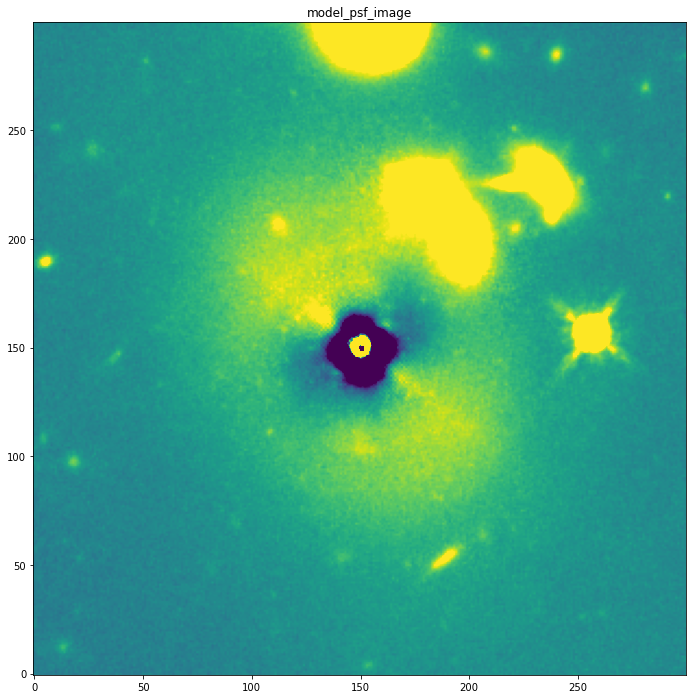

In [15]:
fitted_model, _ = fit_model(
    target_zoom, sersic_model,
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

fitted_model_image = model_to_image(mid, mid, mid*2, fitted_model)

plt.imshow(target_zoom_raw_image-fitted_model_image, vmax=vmax, vmin=vmin)
plt.title("model_psf_image")
plt.show()


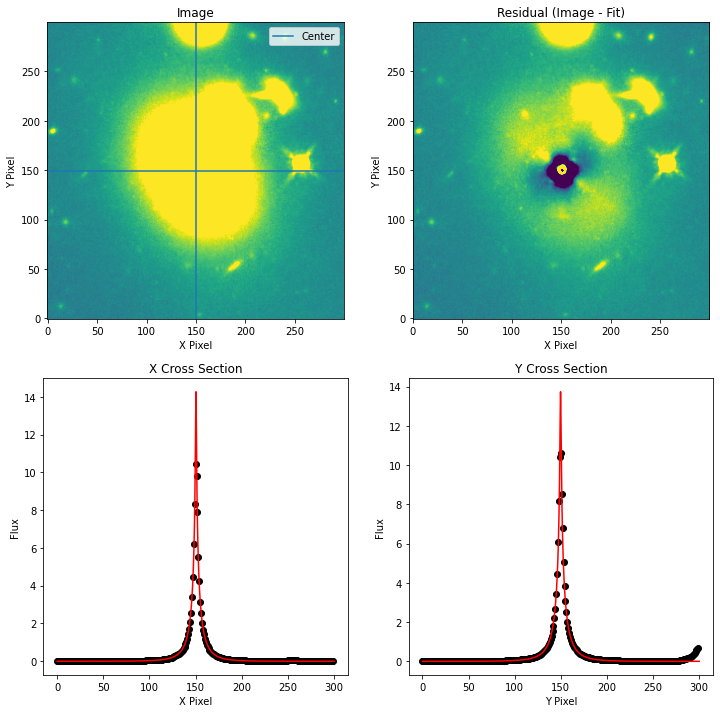

In [16]:
plot_fit(target_zoom_raw_image, fitted_model, vmax=vmax, vmin=vmin);

# PetroFit PSFModel 

Wrap the fitted AstroPy model from the last step and add oversampling if needed. Oversampling of 2-4 is more than enough for an image 100 pix+.

In [17]:
psf_model = PSFModel.wrap(fitted_model, psf=PSF, oversample=2)

# PSF rotation 
psf_model.bounds['psf_pa'] = (-5, 5)
psf_model.fixed['psf_pa'] = True # Do not rotate PSF 

In [18]:
# PSF model 
psf_model

<PSFModel(amplitude=0.59786291, r_eff=17.49017537, n=2.054998, x_0=150.40922232, y_0=149.60356663, ellip=0.14952893, theta=-1.09334727, psf_pa=0.)>

### Fit PSFModel Model

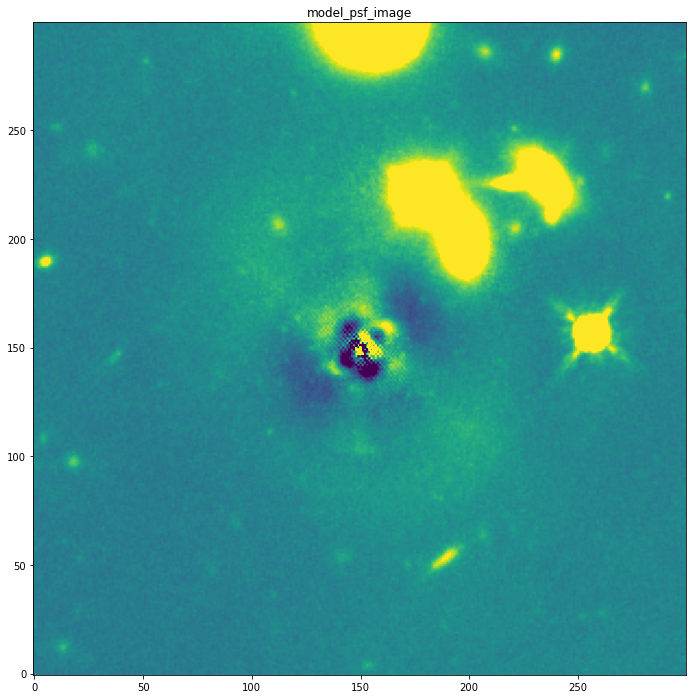

In [19]:
fitted_psf_model, _ = fit_model(
    target_zoom, psf_model,
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

fitted_psf_model_image = model_to_image(mid, mid, mid*2, fitted_psf_model)

plt.imshow(target_zoom_raw_image-fitted_psf_model_image, vmax=vmax, vmin=vmin)
plt.title("model_psf_image")
plt.show()


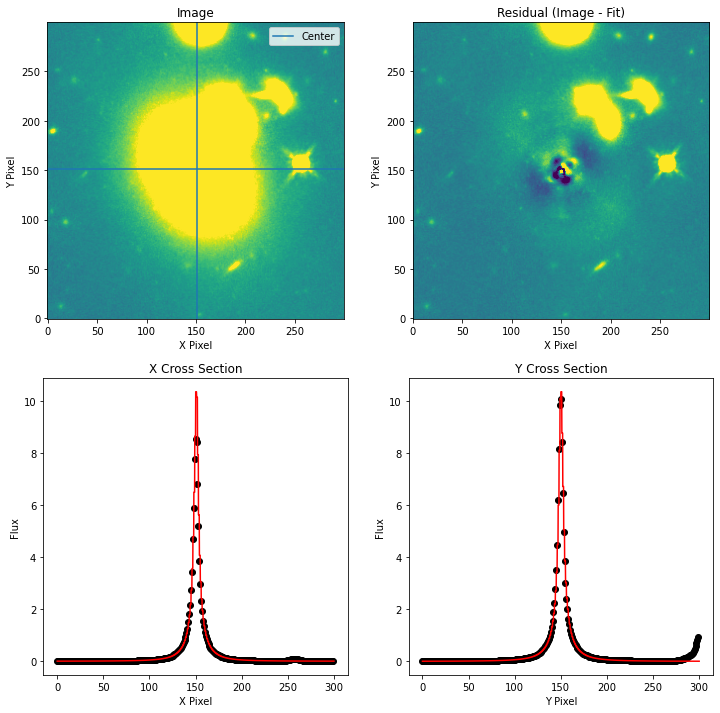

In [20]:
plot_fit(target_zoom_raw_image, fitted_psf_model, vmax=vmax, vmin=vmin);